In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-bvp-nonlinear)=
# Nonlinearity and boundary conditions

```{index} Newton's method
```

Collocation for nonlinear differential equations operates on the same principle as for linear problems: replace functions by vectors and replace derivatives by differentiation matrices. But because the differential equation is nonlinear, the resulting algebraic equations are as well. We will therefore need to use a quasi-Newton or similar method as part of the solution process.

We consider the TPBVP {eq}`tpbvp`, reproduced here:

:::{math}
:label: nonlinbvp
\begin{split}
u''(x) &= \phi(x,u,u'), \qquad a \le x \le b,\\
g_1(u(a),u'(a)) &= 0,\\
g_2(u(b),u'(b)) &= 0.
\end{split}
:::

As in {numref}`section-bvp-linear`, the function $u(x)$ is replaced by a vector $\mathbf{u}$ of its approximated values at nodes $x_0,x_1,\ldots,x_n$ (see Equation {eq}`bvpsolndisc`). We define derivatives of the sampled function as in {eq}`bvpD1` and {eq}`bvpD2`, using suitable differentiation matrices $\mathbf{D}_x$ and $\mathbf{D}_{xx}$. 

The collocation equations, ignoring boundary conditions for now, are

$$
	\mathbf{D}_{xx} \mathbf{u} - \mathbf{r}(\mathbf{u}) = \boldsymbol{0},
$$

where

:::{math}
:label: fdresid
r_i(\mathbf{u}) = \phi(x_i,u_i,u_i'), \qquad i=0,\ldots,n.
:::

and $\mathbf{u}'=\mathbf{D}_x\mathbf{u}$.

We impose the boundary conditions in much the same way as in {numref}`section-bvp-linear`. Again define the rectangular boundary removal matrix $\mathbf{E}$ as in {eq}`rowdeletion`, and replace the equations in those two rows by the boundary conditions:

:::{math}
:label: fdbvp
\mathbf{f}(\mathbf{u}) =
  \begin{bmatrix}
    \mathbf{E} \bigl( \mathbf{D}_{xx}\mathbf{u}  - \mathbf{r}(\mathbf{u}) \bigr) \\[1mm]
    g_1(u_0,u_0') \\[1mm]
    g_2(u_n,u_n')
  \end{bmatrix}
  = \boldsymbol{0}.
:::

The left-hand side of {eq}`fdbvp` is a nonlinear function of the unknowns in the vector $\mathbf{u}$, so {eq}`fdbvp` is an $(n+1)\times 1$ set of nonlinear equations, amenable to solution by the techniques of [Chapter 4](../nonlineqn/overview.md).

(example-fdresidual)=
::::{proof:example}
Given the BVP
  
$$
u'' - \sin(xu) + \exp(xu')=0, \quad u(0)=-2, \; u'(3/2)=1,
$$

we compare to the standard form {eq}`nonlinbvp` and recognize
  
$$
\phi(x,u,u') = \sin(xu)-\exp(xu').
$$

Suppose $n=3$ for an equispaced grid, so that $h=\frac{1}{2}$, $x_0=0$, $x_1=\frac{1}{2}$, $x_2=1$, and $x_3=\frac{3}{2}$. There are four unknowns. We compute
\begin{gather*}
  \mathbf{D}_{xx} = \frac{1}{1/4}
  \begin{bmatrix}
    2    & -5   & 4   & -1    \\ 
    1    & -2   & 1   & 0     \\
    0    & 1    & -2  & 1     \\ 
   -1    &  4   &  -5 & 2
  \end{bmatrix}, \quad
  \mathbf{D}_x = \frac{1}{1}
  \begin{bmatrix}
    -3 & 4 & -1 & 0         \\
    -1 & 0  & 1 & 0       \\
    0  & -1 & 0  & 1     \\ 
    0 & 1 & -4 & 3
  \end{bmatrix},	
  \\[2mm]
  \mathbf{E} \mathbf{r}(\mathbf{u}) =
  \begin{bmatrix}
    \sin\left(\frac{u_1}{2}\right) - \exp\left(\frac{u_2-u_0}{2}\right)      \\[1mm]
    \sin(u_2) - \exp\left( u_3-u_1 \right) 
  \end{bmatrix},
  \\[2mm]
  \mathbf{f}(\mathbf{u}) =
  \begin{bmatrix}
    (4u_0 -8u_1 + 4u_2) - \sin\left(\frac{u_1}{2}\right) + \exp\left(\frac{u_2-u_0}{2}\right) \\[1mm]
    (4u_1 -8u_2 + 4u_3) - \sin(u_2) + \exp\left( u_3-u_1 \right) \\[1mm]
    u_0 + 2                                             \\[1mm]
    (u_1 - 4u_2 + 3u_3) - 1
  \end{bmatrix}.
\end{gather*}		
::::

## Implementation

Our implementation using second-order finite differences is {numref}`Function {number} <function-bvp>`. It's surprisingly short, considering how general it is, because we have laid a lot of groundwork already.

(function-bvp)=
````{proof:function} bvp
**Solve a nonlinear boundary-value problem**
```{code-block} julia1
:lineno-start: 1
"""
    bvp(ϕ,xspan,lval,lder,rval,rder,init)

Finite differences to solve a two-point boundary value problem with
ODE u'' = `ϕ`(x,u,u') for x in `xspan`, left boundary condition 
`g₁`(u,u')=0, and right boundary condition `g₂`(u,u')=0. The value 
`init` is an initial estimate for the values of the solution u at
equally spaced values of x, which also sets the number of nodes.
    
Returns vectors for the nodes and the values of u.
"""
function bvp(ϕ,xspan,g₁,g₂,init)
    n = length(init) - 1
    x,Dₓ,Dₓₓ = diffmat2(n,xspan)
    h = x[2]-x[1]

    function residual(u)
        # Residual of the ODE at the nodes. 
        du_dx = Dₓ*u                   # discrete u'
        d2u_dx2 = Dₓₓ*u                # discrete u''
        f = d2u_dx2 - ϕ.(x,u,du_dx)

        # Replace first and last values by boundary conditions.
        f[1] = g₁(u[1],du_dx[1])/h
        f[n+1] = g₂(u[n+1],du_dx[n+1])/h
        return f
    end
    
    u = levenberg(residual,init)
    return x,u[end]
end
```
````

:::{admonition} About the code
:class: dropdown
The nested function `residual` uses differentiation matrices computed externally to it, rather than computing them anew on each invocation. As in {numref}`Function {number} <function-bvplin>`, there is no need to form the row-deletion matrix $\mathbf{E}$ explicitly. In lines 23--24, we divide the values of $g_1$ and $g_2$ by a factor of $h$. This helps scale the residual components more uniformly and improves the robustness of convergence a bit.
:::

In order to solve a particular problem, we must write a function that computes $\phi$ for vector-valued inputs $\mathbf{x}$, $\mathbf{u}$, and $\mathbf{u}'$, and functions for the boundary conditions. We also have to supply `init`, which is an estimate of the solution used to initialize the quasi-Newton iteration. Since this argument is a vector of length $n+1$, it sets the value of $n$ in the discretization.

(demo-nonlinear-pendulum)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

Suppose a damped pendulum satisfies the nonlinear equation $\theta'' + 0.05\theta'+\sin \theta =0$. We want to start the pendulum at $\theta=2.5$ and give it the right initial velocity so that it reaches $\theta=-2$ at exactly $t=5$. This is a boundary-value problem with Dirichlet conditions $\theta(0)=2.5$ and $\theta(5)=-2$.

The first step is to define the function $\phi$ that equals $\theta''$.

In [2]:
ϕ = (t,θ,ω) -> -0.05*ω - sin(θ);

Next, we define the boundary conditions.

In [3]:
g₁(u,du) = u - 2.5
g₂(u,du) = u + 2;

```{index} ! Julia; collect
```

::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
The last ingredient is an initial estimate of the solution. Here we choose $n=100$ and a linear function between the endpoint values. 

```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```
The `collect` function turns a range object into a true vector.
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

In [4]:
init = collect( range(2.5,-2,length=101) );

We find a solution with negative initial slope, i.e., the pendulum is initially pushed back toward equilibrium.

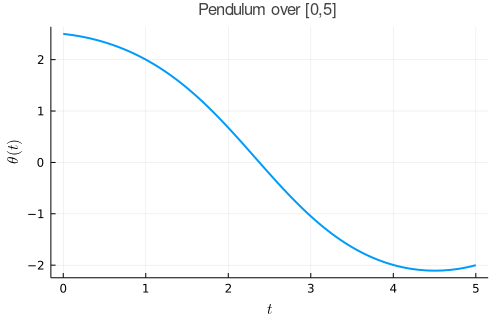

In [5]:
t,θ = FNC.bvp(ϕ,[0,5],g₁,g₂,init)
plot(t,θ,xaxis=(L"t"),yaxis=(L"\theta(t)"),
     title="Pendulum over [0,5]")

If we extend the time interval longer for the same boundary values, then the initial slope must adjust.

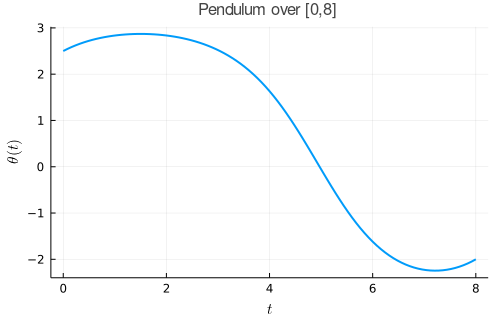

In [6]:
t,θ = FNC.bvp(ϕ,[0,8],g₁,g₂,init)
plot(t,θ,xaxis=(L"t"),yaxis=(L"\theta(t)"),
     title="Pendulum over [0,8]")

This time, the pendulum is initially pushed toward the unstable equilibrium in the upright vertical position before gravity pulls it back down.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

The initial solution estimate can strongly influence how quickly a solution is found, or whether the quasi-Newton iteration converges at all. In situations where multiple solutions exist, the initialization can determine which is found. 
 
(demo-nonlinear-mems)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We look for a solution to the parameterized membrane deflection problem from {numref}`Example {number} <example-tpbvp-mems>`,

$$
w''+ \frac{1}{r}w'= \frac{\lambda}{w^2},\quad w'(0)=0,\; w(1)=1.
$$ 

Here is the problem definition. We use a truncated domain to avoid division by zero at $r=0$.

In [7]:
domain = [eps(),1]
λ = 0.5
ϕ = (r,w,dwdr) -> λ/w^2 - dwdr/r
g₁(w,dw) = dw
g₂(w,dw) = w-1;

First we try a constant function as the initialization.

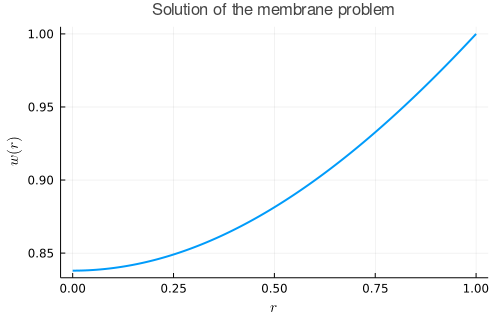

In [8]:
init = ones(301)
r,w₁ = FNC.bvp(ϕ,domain,g₁,g₂,init)

plot(r,w₁,xaxis=(L"r"),yaxis=(L"w(r)"),
     title="Solution of the membrane problem")

It's not necessary that the initialization satisfy the boundary conditions. In fact, by choosing a different constant function as the initial guess, we arrive at another valid solution.

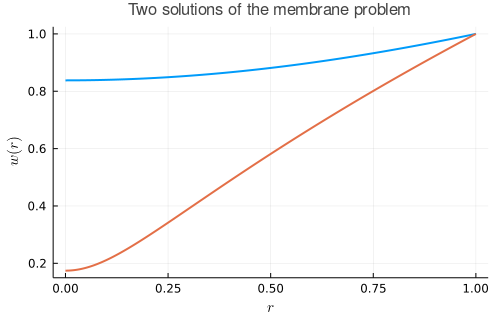

In [9]:
init = 0.5*ones(301)
r,w₂ = FNC.bvp(ϕ,domain,g₁,g₂,init)
plot!(r,w₂,title="Two solutions of the membrane problem")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Parameter continuation

```{index} ! parameter continuation
```

Sometimes the best way to get a useful initialization is to use the solution of a related easier problem, a technique known as **parameter continuation**.  In this approach, one solves the problem at an easy parameter value, and gradually changes the parameter value to the desired value. After each change, the most recent solution is used to initialize the iteration at the new parameter value. 
 

```{index} Allen–Cahn equation
```

(demo-nonlinear-allencahn)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We solve the stationary **Allen–Cahn equation**,
  
$$
\epsilon u'' = u^3-u, \quad 0 \le x \le 1, \quad u'(0)=0, \; u(1)=1.
$$

In [10]:
ϕ = (x,u,dudx) -> (u^3 - u) / ϵ;
g₁(u,du) = du
g₂(u,du) = u-1;

Finding a solution is easy at larger values of $\epsilon$.

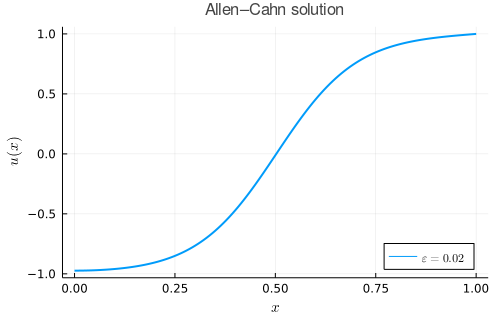

In [11]:
ϵ = 0.02
init = collect( range(-1,1,length=141) )
x,u₁ = FNC.bvp(ϕ,[0,1],g₁,g₂,init)

plot(x,u₁,label=L"\epsilon = 0.02",leg=:bottomright,
    xaxis=(L"x"),yaxis=(L"u(x)"),title="Allen–Cahn solution")

However, finding a good initialization is not trivial for smaller values of $\epsilon$. Note below that the iteration stops without converging to a solution.

In [12]:
ϵ = 0.002;
x,z = FNC.bvp(ϕ,[0,1],g₁,g₂,init);

┌ Warning: Maximum number of iterations reached.
└ @ FundamentalsNumericalComputation /Users/driscoll/.julia/dev/FundamentalsNumericalComputation/src/chapter04.jl:166


The iteration succeeds if we use the first solution instead as the initialization here.

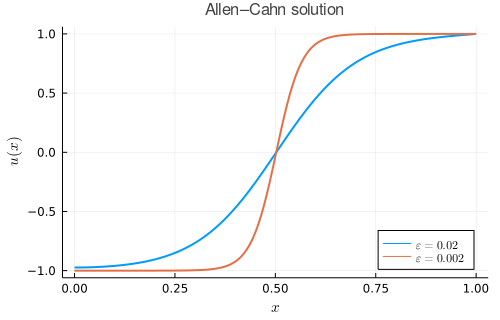

In [13]:
x,u₂ = FNC.bvp(ϕ,[0,1],g₁,g₂,u₁)
plot!(x,u₂,label=L"\epsilon = 0.002")

In this case we can continue further.

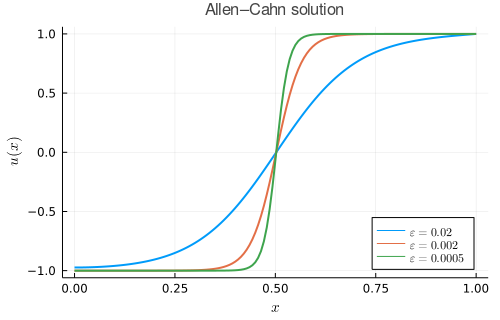

In [14]:
ϵ = 0.0005
x,u₃ = FNC.bvp(ϕ,[0,1],g₁,g₂,u₂)
plot!(x,u₃,label=L"\epsilon = 0.0005")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Exercises

(problem-nonlinear-byhand)=
1. ✍ This exercise is about the nonlinear boundary-value problem

    $$
    u'' = \frac{3(u')^2}{u} , \quad u(-1) = 1, \; u(2) = \frac{1}{2}.
    $$

    **(a)** Verify that the exact solution is $u(x) =  ( x+2 )^{-1/2}$.
    
    **(b)** Write out the finite-difference approximation {eq}`fdbvp` with a single interior point ($n=2$).
    
    **(c)** Solve the equation of part (b) for the lone interior value $u_1$.

2.  ⌨
    **(a)** Use {numref}`Function {number} <function-bvp>` to solve the problem of Exercise 1 for $n=80$. In a 2-by-1 subplot array, plot the finite-difference solution and its error.
    
    **(b)** ⌨ For each $n=10,20,40,\ldots,640$, find the infinity norm of the error on the same problem. Make a log-log plot of error versus $n$ and include a graphical comparison to second-order convergence.

3. ⌨ (Adapted from {cite}`ascherComputerMethods1998`.) Use {numref}`Function {number} <function-bvp>` twice with $n=200$ to solve 

    $$
    u'' +  e^{u+0.5} = 0, \quad y(0) = y(1) = 0,
    $$

    with initializations $7 \sin(x)$ and $\frac{1}{4} \sin(x)$. Plot the solutions together on one graph.

4. ⌨ Use {numref}`Function {number} <function-bvp>` to compute the solution to the Allen–Cahn equation in {numref}`Demo %s <demo-nonlinear-allencahn>` with $\epsilon=0.02$. Determine numerically whether it is antisymmetric around the line $x=0.5$---that is, whether $u(1-x)=-u(x)$. You should supply evidence that your answer is independent of $n$. 

5. ⌨ Consider the pendulum problem from {numref}`Example {number} <example-tpbvp-pendulum>` with $g=L=1$. Suppose we want to release the pendulum from rest such that $\theta(5)=\pi/2$. Use {numref}`Function {number} <function-bvp>` with $n=200$ to find one solution that passes through $\theta=0$, and another solution that does not. Plot $\theta(t)$ for both cases together.

6. ⌨ The BVP
 
    $$
    u'' = x \operatorname{sign}(1-x) u, \quad u(-6)=1, \; u'(6)=0,
    $$

    forces $u''$ to be discontinuous at $x=1$, so finite differences may not converge to the solution at their nominal order of accuracy.

    **(a)** Solve the problem using {numref}`Function {number} <function-bvp>` with $n=1400$, and make a plot of the solution. Store the value at $x=6$ for use as a reference high-accuracy solution.
       
    **(b)** For each $n=100,200,300,\ldots,1000$, apply {numref}`Function {number} <function-bvp>`, and compute the error at $x=6$. Compare the convergence graphically to second order. 

    
    ```{index} Carrier equation
    ```

7. ⌨  The following nonlinear BVP was proposed by Carrier (for the special case $b=1$ in {cite}`carrierSingularPerturbation1970`):

    $$
    \epsilon u'' + 2(1-x^2)u +u^2 = 1, \quad u(-1) = u(1) = 0.
    $$

    In order to balance the different components of the residual, it's best to implement each boundary condition numerically as $u/\epsilon=0$.

    **(a)** Use {numref}`Function {number} <function-bvp>` to solve the problem with $\epsilon=0.003$, $n=200$, and an initial estimate of all zeros. Plot the result; you should get a solution with 9 local maxima.

    **(b)** Starting with the result from part (a) as an initialization, continue the parameter through the sequence

    $$
    \epsilon = 3\times 10^{-3}, 3\times 10^{-2.8}, 3\times 10^{-2.6},\ldots, 3\times 10^{-1}.
    $$

    The most recent solution should be used as the initialization for each new value of $\epsilon$. Plot the end result for $\epsilon=0.3$; it should have one interior local maximum.

    **(c)** Starting with the last solution of part (b), reverse the continuation steps to return to $\epsilon=0.003$. Plot the result, which is an entirely different solution from part (a).

8. ⌨  {numref}`Demo %s <demo-nonlinear-mems>` finds two solutions at $\lambda=0.5$. Continue both solutions by taking 50 steps from $\lambda=0.5$ to $\lambda=0.79$. Make a plot with $\lambda$ on the horizontal axis and $w(0)$ on the vertical axis, with one point to represent each solution found. You should get two paths that converge as $\lambda$ approaches $0.79$ from below.